<a href="https://colab.research.google.com/github/hoootteok2/aix_project/blob/main/AI%2BX_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries



In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Preparation - kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # kaggle.json 파일을 업로드합니다.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seosong","key":"0733434a9fa120b171be1ce950211aa5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet --unzip

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
100% 1.02G/1.03G [00:32<00:00, 32.5MB/s]
100% 1.03G/1.03G [00:32<00:00, 34.3MB/s]


# Data Preparation

In [ ]:
# Paths to your training and testing data
data_dir = '/content/asl_alphabet_train/asl_alphabet_train'
Val_dir = '/content/asl_alphabet_test/asl_alphabet_test'

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
# Get class names
class_names = dataset.classes
num_classes = len(class_names)
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [ ]:
# Define the ratio for train/test split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

In [ ]:
# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
# Get the number of samples in each set
num_train_samples = len(train_dataset)
num_test_samples = len(test_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of testing samples: {num_test_samples}')

Number of training samples: 69600
Number of testing samples: 17400


In [ ]:
num_classes = len(dataset.classes)
num_classes

29

In [ ]:
# Create DataLoaders for training and testing sets
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Example of iterating over the training data
for images, labels in train_loader:
    # Your training code here
    print(images.shape, labels.shape)
    break

# Example of iterating over the testing data
for images, labels in test_loader:
    # Your testing code here
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 200, 200]) torch.Size([32])
torch.Size([32, 3, 200, 200]) torch.Size([32])


In [ ]:
# Function to display random samples
def show_random_samples(dataset, class_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for displaying
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.show()

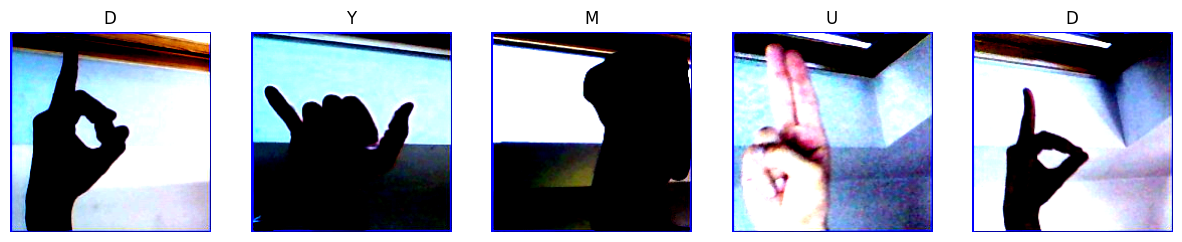

In [ ]:
# Display random samples from the training set
show_random_samples(train_dataset, class_names)

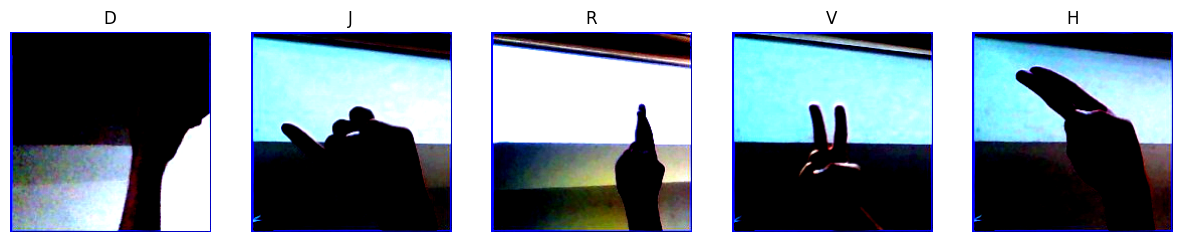

In [ ]:
# Display random samples from the testing set
show_random_samples(test_dataset, class_names)

# Model Architecture - yolov5

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
!pip install yolov5

 yolov5를 우리가 준비한 학습 데이터 셋에 넣어서 굴리는 것
->웹캠에서 나의 손동작을 보고 내 손동작에 따라 어떤 알파벳을 의미하는지 확인해야 함 -> 우선 yolov5로 코드를 작성해보고 이후 yolov7 tiny로 최종 코드 작성할 것

In [ ]:
from yolov5.models.experimental import attempt_load
from yolov5.utils.general import non_max_suppression, scale_coords
from yolov5.utils.plots import Annotator

ImportError: cannot import name 'scale_coords' from 'yolov5.utils.general' (/usr/local/lib/python3.10/dist-packages/yolov5/utils/general.py)

In [ ]:
import cv2
import torch
from yolov5.models.experimental import attempt_load
from yolov5.utils.general import non_max_suppression, scale_coords
from yolov5.utils.plots import Annotator

# YOLOv5 모델 불러오기
weights = 'yolov5s.pt'  # 학습된 모델의 가중치 경로
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = attempt_load(weights, map_location=device)
stride = int(model.stride.max())
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[0, 255, 0]] * len(names)

# 웹캠으로부터 프레임 읽기
cap = cv2.VideoCapture(0)  # 0은 기본 웹캠을 의미

while True:
    ret, frame = cap.read()  # 프레임 읽기
    if not ret:
        break

    # YOLOv5를 통한 객체 감지 및 결과 시각화
    pred = model(frame, size=stride)  # YOLOv5를 통한 객체 감지
    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45)  # 비최대 억제 적용

    annotator = Annotator(frame, line_width=3, text_size=2)  # 시각화 도구 생성

    if pred[0] is not None:
        pred[0][:, :4] = scale_coords(frame.shape[2:], pred[0][:, :4], frame.shape).round()  # 좌표 스케일링
        for *xyxy, conf, cls in reversed(pred[0]):
            annotator.box_label(xyxy, names[int(cls)], color=colors[int(cls)])  # 박스와 라벨 시각화

    frame = annotator.result()  # 최종 결과 프레임

    # 결과 화면에 표시
    cv2.imshow('YOLOv5 Object Detection', frame)  # 결과 프레임 화면에 표시

    if cv2.waitKey(1) == ord('q'):  # 'q' 키를 누르면 종료
        break

cap.release()
cv2.destroyAllWindows()


ImportError: cannot import name 'scale_coords' from 'yolov5.utils.general' (/usr/local/lib/python3.10/dist-packages/yolov5/utils/general.py)